# 📖 Introducción  

El electroencefalograma (EEG) es una técnica no invasiva utilizada para registrar la actividad eléctrica del cerebro mediante electrodos superficiales colocados en el cuero cabelludo. Esta señal refleja la suma de potenciales postsinápticos generados principalmente por neuronas piramidales corticales, y se organiza en bandas de frecuencia que se asocian con distintos estados fisiológicos y cognitivos: δ (0.5–4 Hz) en sueño profundo, θ (4–8 Hz) en somnolencia y navegación espacial, α (8–13 Hz) en estados de reposo con ojos cerrados, y β (13–30 Hz) durante la atención y el procesamiento cognitivo. [1] [2]

La práctica busca introducir al estudiante en la adquisición e interpretación de señales EEG, diferenciando entre condiciones de reposo, tareas cognitivas y artefactos controlados. El análisis de estas variaciones permite comprender la dinámica cerebral y la importancia del procesamiento de señales biomédicas en aplicaciones clínicas y de investigación.

# 🎯 Objetivos del laboratorio

- Montar y configurar el sistema **BITalino (r)evolution Board Kit** para adquisición EEG.  
- Registrar la actividad eléctrica cerebral en condiciones experimentales específicas (basal, cognitiva, libre y artefactos).  
- Identificar los cambios en la potencia de bandas EEG según el estado del participante.  
- Diferenciar entre señales fisiológicas genuinas y artefactos de origen muscular u ocular.  
- Aplicar filtros adecuados y reconocer la utilidad del análisis espectral en neurociencia.

## 👾 Extra
- Montar y configurar el sistema **Ultracortex Mark M IV** como otro método de adquisición de EEG.
- Registrar la actividad eléctrica cerebral en las mismas condiciones experimentales.
- Identificar los cambios en la potencia de bandas EEG según el estado del participante.  
- Diferenciar entre señales fisiológicas genuinas y artefactos de origen muscular u ocular.  
- Aplicar filtros adecuados y reconocer la utilidad del análisis espectral en neurociencia.
- Identificar las diferencias entre ambos métodos de adquisición de EEG.

# 👨🏻‍💻 MATERIALES

<p align="center">
  <img src="../../Imagenes/Materiales.jpeg" alt="Materiales" width="600">
</p>

***Figura 01 - Materiales usados en el laboratorio del 17 de setiembre 2025***



- **LAPTOP** – La laptop se utiliza para correr el software [**OpenSignals**](https://support.pluxbiosignals.com/knowledge-base/introducing-opensignals-revolution/), que permite visualizar, registrar y analizar en tiempo real las señales adquiridas por el BITalino.  
  <p align="center">
    <img src="https://i.dell.com/is/image/DellContent/content/dam/ss2/product-images/dell-client-products/notebooks/dell-plus/db14255/media-gallery/touch/fpr/laptop-db14255t-bl-fpr-gallery-2.psd?fmt=png-alpha&pscan=auto&scl=1&hei=804&wid=975&qlt=100,1&resMode=sharp2&size=975,804&chrss=full" width="250"/>
  </p> 

***Figura 02 - Imagen referencial de laptop con OpenSignals***


- **Un microcontrolador BITalino para adquisición de bioseñales** – El **BITalino** es una placa biomédica de bajo costo diseñada para adquirir señales fisiológicas como ECG, EMG, EDA o acelerómetro. Se usa en investigación, docencia y prototipado.  
  <p align="center">
    <img src="https://prototipadolab.com/wp-content/uploads/2018/08/bitalino.jpg" width="250"/>
  </p>

***Figura 03 - BITalino***

- **3 Electrodos desechables** – Son adhesivos con gel conductor que se colocan sobre la piel para captar la actividad eléctrica. Son de un solo uso para asegurar buena calidad de señal e higiene.  
  <p align="center">
    <img src="https://mecatronica.saisac.pe/wp-content/uploads/2024/10/ELECTRODO.png" width="250"/>
  </p>  

***Figura 04 - Electrodos deshechables***

- **3 cables de electrodos (Lead I, sistema de 3 electrodos)** – El **Lead I** en configuración de 3 electrodos se coloca en brazo derecho, brazo izquierdo y pierna derecha (tierra). Permite medir la diferencia de potencial entre ambos brazos para el registro de ECG.  
  <p align="center">
    <img src="https://mecatronica.saisac.pe/wp-content/uploads/2024/10/CABLEELECTRODO.png" width="250"/>
  </p>

***Figura 05 - Lead I Sistema de 3 electrodos***

- **Ultracortex Mark M IV** Es un casco abierto y ajustable de código abierto diseñado para montar electrodos EEG de manera flexible y cómoda en aplicaciones de neurotecnología.
  <p align="center">
    <img src="https://docs.openbci.com/assets/images/UCM4-Product-2-28967dab0bd940f3b3fe67d2c7d9fcdb.JPG" width="250"/>
  </p>

***Figura 06 - Ultracortex Mark M IV***

# 🔬 Metodología de laboratorio para EEG con BITalino

## 1️⃣ Preparación de equipos y software 💻
Para empezar, se instaló el software **OpenSignals (r)evolution**. Se conectó el dispositivo **BITalino (r)evolution Board Kit BLE/BT** a una laptop con Bluetooth. El canal A4 se configuró como EEG, y se ajustó la frecuencia de muestreo a 1000 Hz, lo cual cumple con el criterio de Nyquist para una banda de 48 Hz. Se creó una carpeta para guardar los datos, y se verificó que la batería del BITalino estuviera por encima del 30%.

## 2️⃣ Montaje de electrodos 🧠
Se limpió la piel en las ubicaciones Fp1, Fp2 y la mastoide. Se conectaron tres electrodos de Ag/AgCl de la siguiente manera: el **Electrodo1** se colocó en Fp1, el electrodo de tierra (GND) en Fp2, y el **Electrodo2** en la mastoide, que actuó como referencia. En el software OpenSignals, se verificó que la impedancia fuera menor a $20~\text{K}\Omega$ para asegurar una señal de calidad. 

![Posicion electrodos](https://class.textile-academy.org/2022/ninon-masclef/images/project/placement.PNG)

***Figura 07 - Posición de los electrodos para adquisición del EEG***


## 3️⃣ Secuencia de registro ⏳
Las grabaciones de la señal EEG se realizaron en segmentos controlados:
* **Minutos 0-1**: Se grabó la señal basal con los ojos abiertos, fijando la mirada en un punto.
* **Minutos 1-2**: Se grabó la señal basal con los ojos cerrados para observar los ritmos alfa.
* **Minutos 2-4**: Se realizó una tarea cognitiva como restar 7 desde 100 en silencio.
* **Minutos 4-6**: Se provocaron artefactos controlados, como parpadear cada 2 segundos y masticar.
* **Minutos 6-12**: Se permitió una grabación libre, donde el grupo optó por escuchar música.

## 4️⃣ Análisis de datos y filtrado 📈
Los datos se exportaron en formato .txt y .csv. Se aplicó un filtro de paso de banda para eliminar ruido de la red eléctrica y otras interferencias. Posteriormente, se realizaron los siguientes análisis:
* **Comparación de ritmos**: Se comparó la potencia de la banda alfa en las condiciones de ojos abiertos y cerrados usando la densidad espectral de potencia (PSD) de Welch.
* **Evaluación de tarea cognitiva**: Se evaluó el incremento de la banda beta durante la tarea cognitiva usando una prueba t-test pareada.
* **Detección de artefactos**: Se contabilizaron los artefactos de parpadeo, identificados por tener una amplitud mayor a $80~\mu\text{V}$.

# 🔬 Metodología de laboratorio para EEG con Ultracortex Mark M IV

## 1️⃣ Preparación de equipos y software 💻
Para empezar, se instaló el software **OpenBCI GUI**. Se conectó el dispositivo **Ultracortex Mark M IV** a una laptop con Bluetooth. A diferencia del bitalino, este dispositivo tiene la opción de autoconectividad para iniciar la toma de datos.

## 2️⃣ Montaje de electrodos 🧠
A diferencia de lo que se requiere para el BITalino, los electrodos del **Ultracortex** son de peine, y ya estan posicionados en el casco abierto para la toma de cada uno de los datos.


![Posicion electrodos](https://images.squarespace-cdn.com/content/v1/673dcab4b177644177af9c16/fdca3d07-7fee-4921-8dc1-701f7d6b56f4/the-10-20-system-with-percentages.gif)

***Figura 08 - Posición de los electrodos para adquisición del EEG con el Ultracortex [3]***


## 3️⃣ Secuencia de registro ⏳
Las grabaciones de la señal EEG se realizaron en segmentos controlados:
* **Minutos 0-1**: Se grabó la señal basal con los ojos abiertos, fijando la mirada en un punto.
* **Minutos 1-2**: Se grabó la señal basal con los ojos cerrados para observar los ritmos alfa.
* **Minutos 2-4**: Se realizó una tarea cognitiva como restar 5 desde 100 en silencio.
* **Minutos 4-6**: Se provocaron artefactos controlados, como parpadear cada 2 segundos (por 1 minuto) y masticar (por 1 minuto).
* **Minutos 6-12**: Se permitió una grabación libre, donde el grupo optó por escuchar música.

## 4️⃣ Análisis de datos y filtrado 📈
Los datos se exportaron en formato .txt y .csv. Se aplicó un filtro de paso de banda para eliminar ruido de la red eléctrica y otras interferencias. Posteriormente, se realizaron los mismos análisis que con el BITalino para su posterior comparación.

# ✨ Resultados

## 1️⃣ Toma de datos - Basal 1 (1–2 min, ojos abiertos - punto fijo)
La señal basal con ojos abiertos muestra una amplitud baja y estable, dentro del rango esperado para un EEG en reposo, sin artefactos evidentes de parpadeo o movimiento.

En el zoom de 5 segundos se observa una actividad rápida con poca presencia de ondas alfa, lo cual concuerda con la condición de ojos abiertos y atención visual.

El espectro de potencia se concentra en frecuencias bajas (<10 Hz) y no presenta un pico marcado en la banda alfa, manteniéndose relativamente plano en frecuencias medias y altas.

Para ver el video de la prueba 1 hacer clic [aqui](https://github.com/angelcebrianupch/GRUPO-02-ISB-2025-II/issues/3#issue-3438639948)

[Basal 1] Potencias (µV²)  α:6.895  β:9.267  γ:2.405


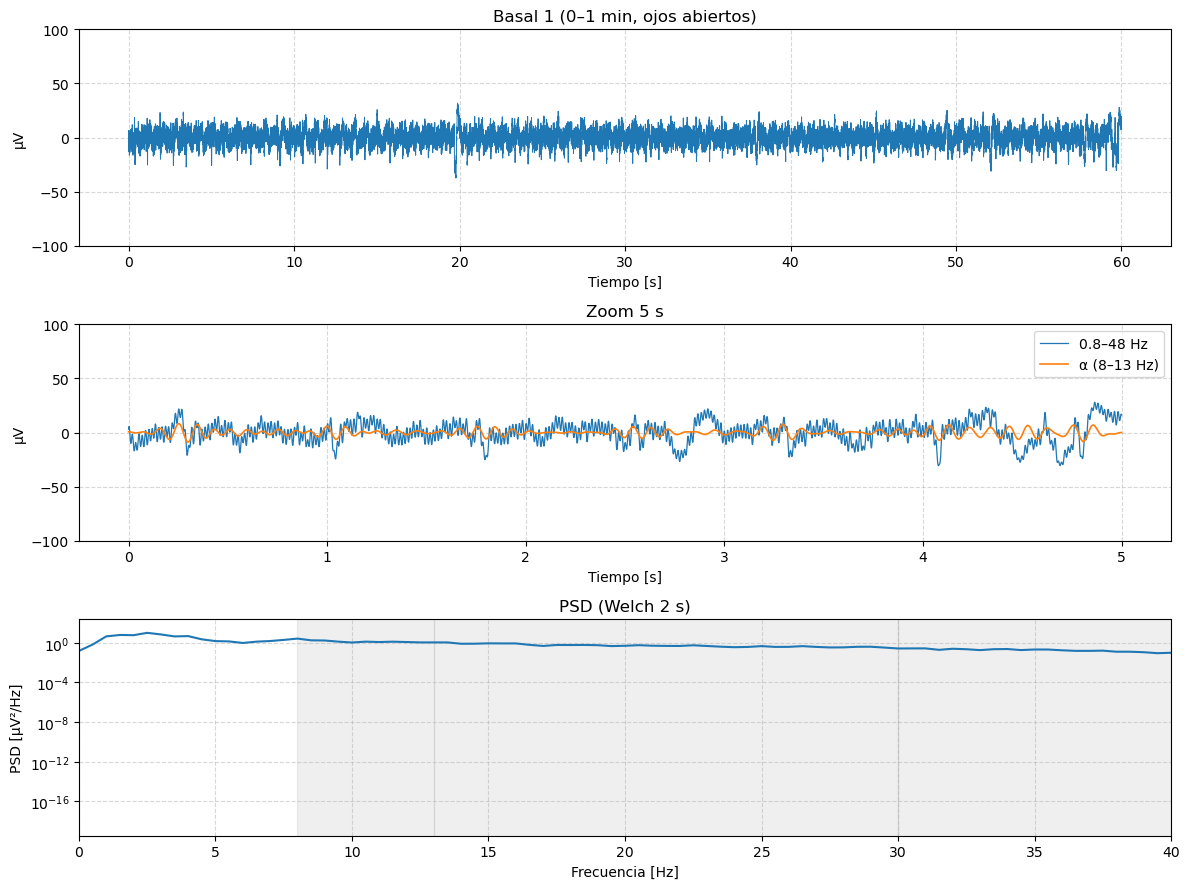

In [2]:
import json, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ===== Config =====
ruta = "Data_EEG/lab5.txt"
bloque = (0, 60)                # 0–1 min
zoom_window = 5.0               # s
f_lo, f_hi = 0.8, 48.0          # Hz
red, Q_notch = 50.0, 30.0       # cambia red=60.0 si tu red es 60 Hz
BANDAS = {"alpha": (8,13), "beta": (13,30), "gamma": (30,48)}

# ===== Leer header (fs y columna A4) =====
with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
    hdr = []
    while True:
        p = f.tell(); ln = f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ===== Cargar y convertir ADC→µV (BITalino EEG) =====
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float)
adc = adc[~np.isnan(adc)]
x = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6  # µV

# ===== Filtros: notch + band-pass =====
bN, aN = iirnotch(red/(fs/2), Q_notch)
x = filtfilt(bN, aN, x, method="gust")
bB, aB = butter(4, [f_lo/(fs/2), f_hi/(fs/2)], btype="band")
x = filtfilt(bB, aB, x, method="gust")

# ===== Recorte del bloque =====
i1, i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x))
t = np.arange(len(x))/fs
t_seg, x_seg = t[i1:i2], x[i1:i2]

# ===== Welch (2 s) y potencias por banda (np.trapezoid) =====
f, Pxx = welch(x_seg, fs=fs, nperseg=2*fs, noverlap=fs)
def band_power(f, P, a, b):
    m = (f >= a) & (f <= b)
    return np.trapezoid(P[m], f[m]) if np.any(m) else 0.0
bp = {k: band_power(f, Pxx, a, b) for k,(a,b) in BANDAS.items()}
print("[Basal 1] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ===== Zoom 5 s (final del bloque) y α superpuesta =====
t2z = t_seg[-1]; t1z = max(t2z - zoom_window, t_seg[0])
j1, j2 = int(t1z*fs), int(t2z*fs)
t_zoom, x_zoom = t[j1:j2], x[j1:j2]
bA, aA = butter(4, [8/(fs/2), 13/(fs/2)], btype="band")
x_alpha = filtfilt(bA, aA, x_zoom, method="gust")

# ===== Gráficas =====
plt.figure(figsize=(12,9))
ax1 = plt.subplot(3,1,1); ax1.plot(t_seg - t_seg[0], x_seg, lw=.7)
ax1.set_title("Basal 1 (0–1 min, ojos abiertos)"); ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True, ls="--", alpha=.5); ax1.set_ylim(-100, 100)

ax2 = plt.subplot(3,1,2)
ax2.plot(t_zoom - t_zoom[0], x_zoom, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom - t_zoom[0], x_alpha, lw=1.2, label="α (8–13 Hz)")
ax2.set_title("Zoom 5 s"); ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True, ls="--", alpha=.5); ax2.legend(); ax2.set_ylim(-100, 100)

ax3 = plt.subplot(3,1,3)
ax3.semilogy(f, Pxx)
for a,b in BANDAS.values(): ax3.axvspan(a, b, color="grey", alpha=.12)
ax3.set_xlim(0, 40); ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)"); ax3.grid(True, ls="--", alpha=.5)
plt.tight_layout(); plt.show()


## 2️⃣ Toma de datos - Basal 2 (1–2 min, ojos cerrados)
La señal en el tiempo muestra mayor regularidad que en la condición de ojos abiertos, con oscilaciones más claras y de mayor amplitud.

En el zoom de 5 segundos se aprecia una presencia marcada de ondas alfa (8–13 Hz), que siguen de cerca el trazo de la señal, lo cual es característico del EEG con ojos cerrados.

El espectro de potencia refleja un incremento en la banda baja, especialmente alrededor de la zona alfa, mostrando así la activación típica de este ritmo en estado de reposo con ojos cerrados.

Para ver el video de la prueba 2 hacer clic [aqui](https://github.com/angelcebrianupch/GRUPO-02-ISB-2025-II/issues/4#issue-3438672418)

[Basal 1] Potencias (µV²)  α:33.567  β:23.864  γ:4.100


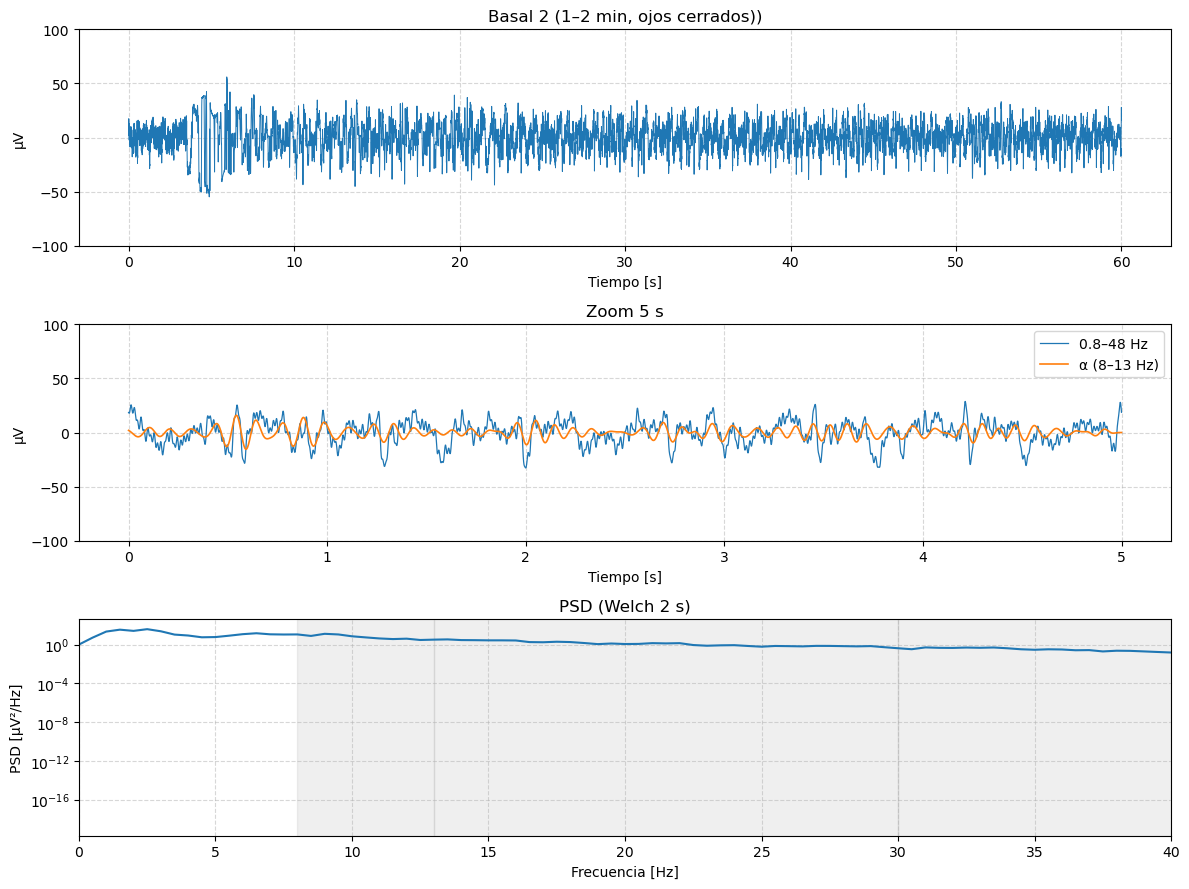

In [8]:
import json, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ===== Config =====
ruta = "Data_EEG/lab5.txt"
bloque = (60, 120)                # 1–2 min
zoom_window = 5.0               # s
f_lo, f_hi = 0.8, 48.0          # Hz
red, Q_notch = 50.0, 30.0       # cambia red=60.0 si tu red es 60 Hz
BANDAS = {"alpha": (8,13), "beta": (13,30), "gamma": (30,48)}

# ===== Leer header (fs y columna A4) =====
with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
    hdr = []
    while True:
        p = f.tell(); ln = f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ===== Cargar y convertir ADC→µV (BITalino EEG) =====
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float)
adc = adc[~np.isnan(adc)]
x = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6  # µV

# ===== Filtros: notch + band-pass =====
bN, aN = iirnotch(red/(fs/2), Q_notch)
x = filtfilt(bN, aN, x, method="gust")
bB, aB = butter(4, [f_lo/(fs/2), f_hi/(fs/2)], btype="band")
x = filtfilt(bB, aB, x, method="gust")

# ===== Recorte del bloque =====
i1, i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x))
t = np.arange(len(x))/fs
t_seg, x_seg = t[i1:i2], x[i1:i2]

# ===== Welch (2 s) y potencias por banda (np.trapezoid) =====
f, Pxx = welch(x_seg, fs=fs, nperseg=2*fs, noverlap=fs)
def band_power(f, P, a, b):
    m = (f >= a) & (f <= b)
    return np.trapezoid(P[m], f[m]) if np.any(m) else 0.0
bp = {k: band_power(f, Pxx, a, b) for k,(a,b) in BANDAS.items()}
print("[Basal 1] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ===== Zoom 5 s (final del bloque) y α superpuesta =====
t2z = t_seg[-1]; t1z = max(t2z - zoom_window, t_seg[0])
j1, j2 = int(t1z*fs), int(t2z*fs)
t_zoom, x_zoom = t[j1:j2], x[j1:j2]
bA, aA = butter(4, [8/(fs/2), 13/(fs/2)], btype="band")
x_alpha = filtfilt(bA, aA, x_zoom, method="gust")

# ===== Gráficas =====
plt.figure(figsize=(12,9))
ax1 = plt.subplot(3,1,1); ax1.plot(t_seg - t_seg[0], x_seg, lw=.7)
ax1.set_title("Basal 2 (1–2 min, ojos cerrados))"); ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True, ls="--", alpha=.5); ax1.set_ylim(-100, 100)

ax2 = plt.subplot(3,1,2)
ax2.plot(t_zoom - t_zoom[0], x_zoom, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom - t_zoom[0], x_alpha, lw=1.2, label="α (8–13 Hz)")
ax2.set_title("Zoom 5 s"); ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True, ls="--", alpha=.5); ax2.legend(); ax2.set_ylim(-100, 100)

ax3 = plt.subplot(3,1,3)
ax3.semilogy(f, Pxx)
for a,b in BANDAS.values(): ax3.axvspan(a, b, color="grey", alpha=.12)
ax3.set_xlim(0, 40); ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)"); ax3.grid(True, ls="--", alpha=.5)
plt.tight_layout(); plt.show()


# 3️⃣ Toma de datos - Tarea cognitiva (2–4 min)
La señal en el tiempo se mantiene con amplitud baja y estable, aunque aparecen algunos picos aislados probablemente asociados a artefactos.

En el zoom de 5 segundos se observa una reducción clara de la actividad alfa, con oscilaciones rápidas y de menor regularidad, lo que refleja el esfuerzo cognitivo durante la tarea.

El espectro de potencia no muestra un pico destacado en la banda alfa y presenta una distribución más uniforme, consistente con el estado de concentración y procesamiento mental.

Para ver el video de la prueba 3 hacer clic [aqui](https://github.com/angelcebrianupch/GRUPO-02-ISB-2025-II/issues/5#issue-3438678199)

[Basal 1] Potencias (µV²)  α:10.125  β:8.766  γ:1.827


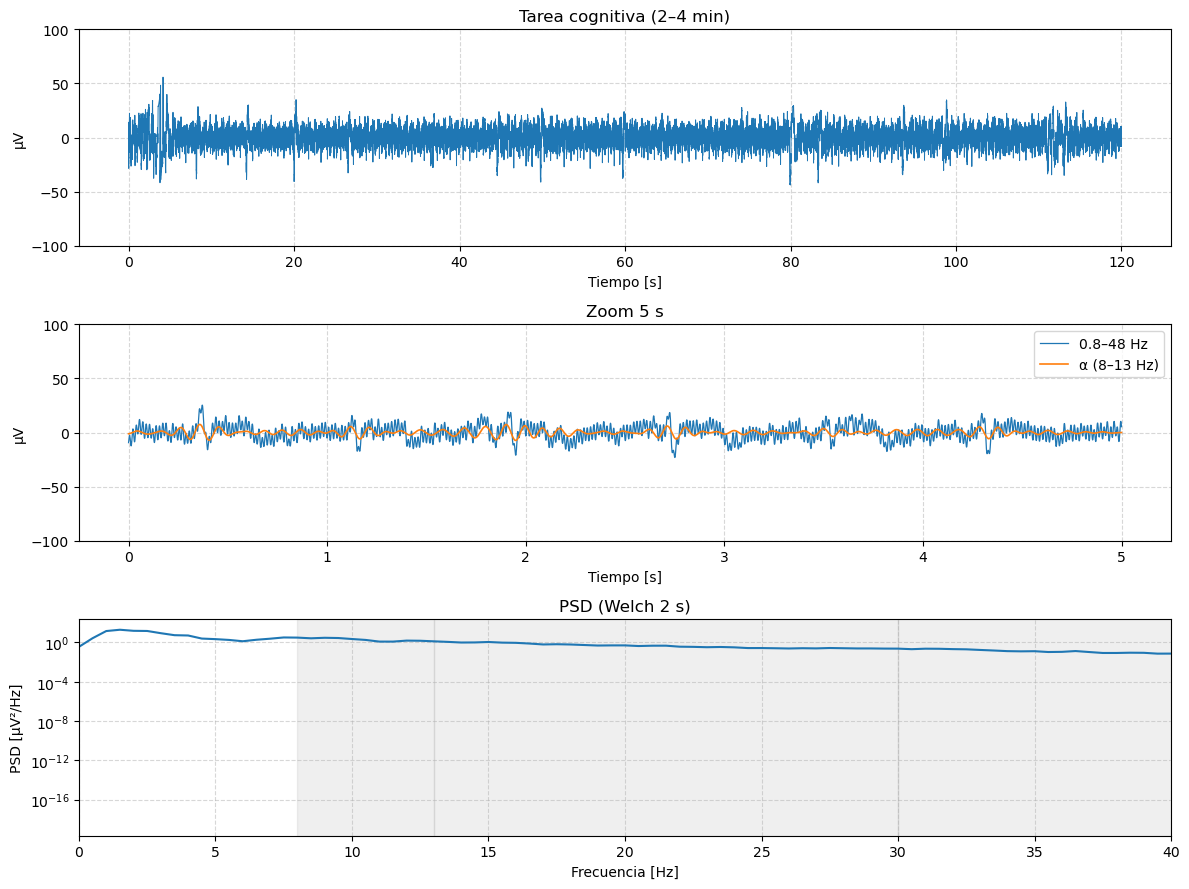

In [9]:
import json, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ===== Config =====
ruta = "Data_EEG/lab5.txt"
bloque = (120, 240)                # 2–4 min
zoom_window = 5.0               # s
f_lo, f_hi = 0.8, 48.0          # Hz
red, Q_notch = 50.0, 30.0       # cambia red=60.0 si tu red es 60 Hz
BANDAS = {"alpha": (8,13), "beta": (13,30), "gamma": (30,48)}

# ===== Leer header (fs y columna A4) =====
with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
    hdr = []
    while True:
        p = f.tell(); ln = f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ===== Cargar y convertir ADC→µV (BITalino EEG) =====
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float)
adc = adc[~np.isnan(adc)]
x = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6  # µV

# ===== Filtros: notch + band-pass =====
bN, aN = iirnotch(red/(fs/2), Q_notch)
x = filtfilt(bN, aN, x, method="gust")
bB, aB = butter(4, [f_lo/(fs/2), f_hi/(fs/2)], btype="band")
x = filtfilt(bB, aB, x, method="gust")

# ===== Recorte del bloque =====
i1, i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x))
t = np.arange(len(x))/fs
t_seg, x_seg = t[i1:i2], x[i1:i2]

# ===== Welch (2 s) y potencias por banda (np.trapezoid) =====
f, Pxx = welch(x_seg, fs=fs, nperseg=2*fs, noverlap=fs)
def band_power(f, P, a, b):
    m = (f >= a) & (f <= b)
    return np.trapezoid(P[m], f[m]) if np.any(m) else 0.0
bp = {k: band_power(f, Pxx, a, b) for k,(a,b) in BANDAS.items()}
print("[Basal 1] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ===== Zoom 5 s (final del bloque) y α superpuesta =====
t2z = t_seg[-1]; t1z = max(t2z - zoom_window, t_seg[0])
j1, j2 = int(t1z*fs), int(t2z*fs)
t_zoom, x_zoom = t[j1:j2], x[j1:j2]
bA, aA = butter(4, [8/(fs/2), 13/(fs/2)], btype="band")
x_alpha = filtfilt(bA, aA, x_zoom, method="gust")

# ===== Gráficas =====
plt.figure(figsize=(12,9))
ax1 = plt.subplot(3,1,1); ax1.plot(t_seg - t_seg[0], x_seg, lw=.7)
ax1.set_title("Tarea cognitiva (2–4 min)"); ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True, ls="--", alpha=.5); ax1.set_ylim(-100, 100)

ax2 = plt.subplot(3,1,2)
ax2.plot(t_zoom - t_zoom[0], x_zoom, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom - t_zoom[0], x_alpha, lw=1.2, label="α (8–13 Hz)")
ax2.set_title("Zoom 5 s"); ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True, ls="--", alpha=.5); ax2.legend(); ax2.set_ylim(-100, 100)

ax3 = plt.subplot(3,1,3)
ax3.semilogy(f, Pxx)
for a,b in BANDAS.values(): ax3.axvspan(a, b, color="grey", alpha=.12)
ax3.set_xlim(0, 40); ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)"); ax3.grid(True, ls="--", alpha=.5)
plt.tight_layout(); plt.show()

# 4️⃣ Toma de datos - Artefactos (4–6 min) + parpadeos y masticar
La señal de EEG presentada muestra la detección de artefactos asociados a parpadeos en un intervalo de 4 a 6 minutos. En la primera gráfica se observa la señal cruda con filtrado en el rango de 0.8–48 Hz, donde los parpadeos generan deflexiones marcadas. En la segunda gráfica, con un zoom de 5 segundos y filtrado pasabajas de 8 Hz, se aprecian con mayor claridad las ondas lentas características de los parpadeos. Finalmente, el análisis espectral (PSD) mediante Welch revela que la mayor parte de la energía se concentra en bajas frecuencias, lo que coincide con la naturaleza de estos artefactos oculares.

Para ver el video de la prueba 4 hacer clic [aqui](https://github.com/angelcebrianupch/GRUPO-02-ISB-2025-II/issues/6#issue-3438678359)

[DEBUG] fs=1000 Hz, p95(|LP8|)≈35.4 µV, MAD≈6.5, sigma≈9.6
[DEBUG] thr_mad≈45.0 µV, thr_rms≈34.8, z-thr=3.0
[Artefactos] Parpadeos detectados: 25
[Artefactos] Potencias (µV²)  α:9.666  β:15.319  γ:5.169


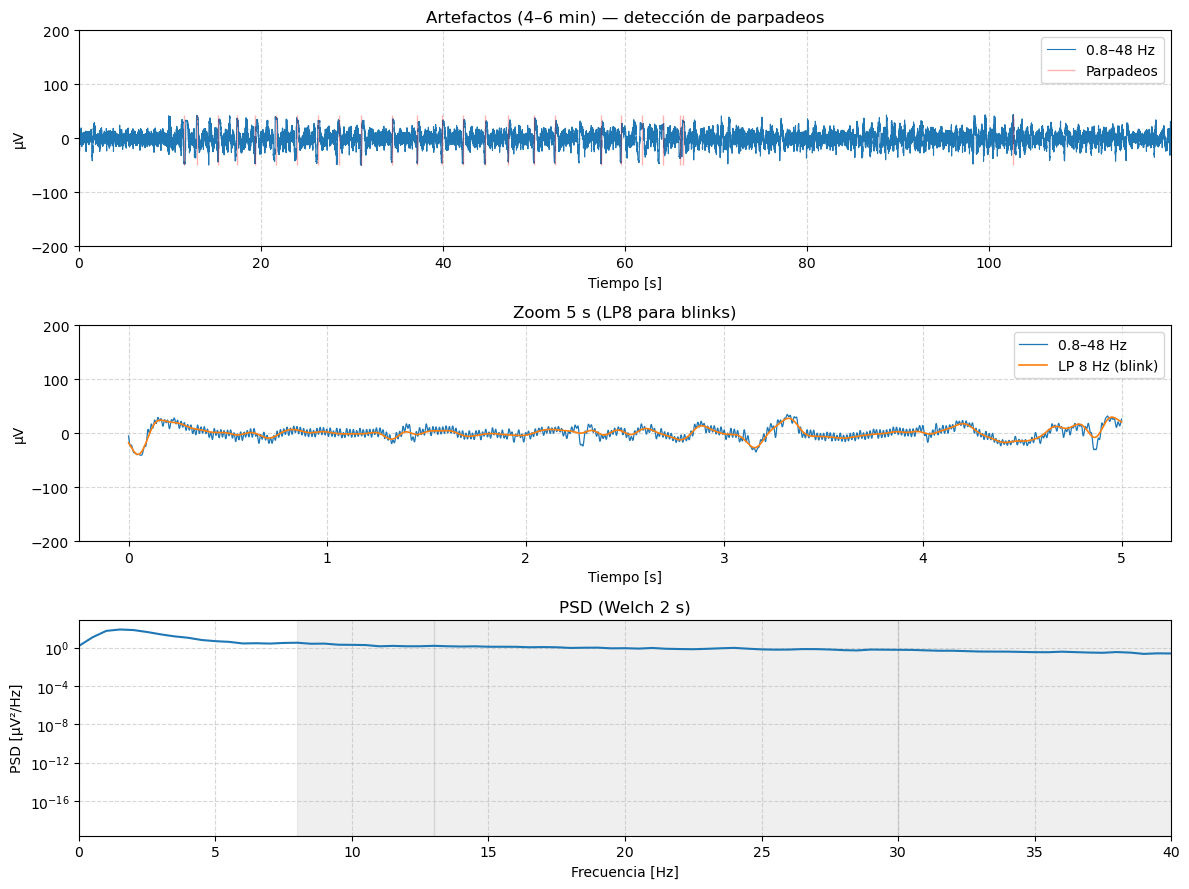

In [10]:
# EEG_04-06_artefactos.py  —  Detección de parpadeos (corregido y robusto)

import json, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch, find_peaks

# ================== Config ==================
ruta = "Data_EEG/lab5.txt"
bloque = (240, 360)          # 4–6 min
zoom_window = 5.0            # s

# Visualización/PSD:
viz_lo, viz_hi = 0.8, 48.0   # Hz

# Detección de parpadeos (señal blanda):
lp_cut = 8.0                 # Hz (LOWPASS para blinks)
red, Q_notch = 50.0, 30.0    # 50 Hz Perú; usa 60.0 si corresponde

# Parámetros de decisión (ajustables)
REFRACT = 0.30               # s – distancia mínima entre blinks
W_MIN, W_MAX = 0.05, 0.60    # s – ancho típico
PROM_MIN = 5.0               # µV – prominencia mínima
Z_THR = 3.0                  # umbral z-score
RMS_WIN = 0.150              # s – ventana RMS
RMS_K = 3.0                  # multiplicador para umbral RMS
MAD_K = 4.0                  # multiplicador MAD
FLOOR_UV = 10.0              # µV – piso mínimo de umbral

BANDAS = {"alpha": (8,13), "beta": (13,30), "gamma": (30,48)}

# ================== Utilidades ==================
def make_butter_low(fc, fs, order=4):
    ny = fs/2
    return butter(order, fc/ny, btype="low")

def make_butter_band(lo, hi, fs, order=4):
    ny = fs/2
    return butter(order, [lo/ny, hi/ny], btype="band")

def safe_filtfilt(b, a, x):
    """filtfilt tolerante a segmentos cortos/ruidosos."""
    x = np.asarray(x, float)
    n = max(len(a), len(b))
    padlen = max(0, min(3*(n-1), x.size-1))
    return filtfilt(b, a, x, method="pad", padlen=padlen)

def fill_nonfinite(x):
    """Interpola NaN/Inf y extrapola bordes."""
    x = np.asarray(x, float)
    ok = np.isfinite(x)
    if ok.all():
        return x
    idx = np.arange(x.size)
    if ok.any():
        y = np.interp(idx, idx[ok], x[ok])
        first, last = np.flatnonzero(ok)[0], np.flatnonzero(ok)[-1]
        y[:first] = y[first]; y[last+1:] = y[last]
        return y
    return np.zeros_like(x)

def band_power(f, P, a, b):
    m = (f>=a) & (f<=b)
    return np.trapezoid(P[m], f[m]) if np.any(m) else 0.0

def merge_peaks(peaks_list, fs, refract_s):
    """Une listas de picos respetando periodo refractario."""
    arrs = [p for p in peaks_list if p is not None and p.size>0]
    if not arrs: return np.array([], int)
    all_idx = np.unique(np.concatenate(arrs))
    if all_idx.size == 0: return all_idx
    all_idx.sort()
    merged = [all_idx[0]]
    refr = int(refract_s*fs)
    for k in all_idx[1:]:
        if k - merged[-1] >= refr:
            merged.append(k)
    return np.array(merged, int)

# ================== Leer header (fs y columna A4) ==================
with open(ruta,"r",encoding="utf-8",errors="ignore") as f:
    hdr=[]
    while True:
        p=f.tell(); ln=f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ================== Cargar y convertir ADC→µV ==================
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float,
                    autostrip=True, invalid_raise=False, filling_values=np.nan)
adc = fill_nonfinite(adc)
x_uV = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6
x_uV = fill_nonfinite(x_uV)

# ================== Notch ==================
bN, aN = iirnotch(red/(fs/2), Q_notch)
x_uV = safe_filtfilt(bN, aN, x_uV)

# ================== Señales filtradas ==================
# Visualización (0.8–48 Hz)
bViz, aViz = make_butter_band(viz_lo, viz_hi, fs, order=4)
x_viz = safe_filtfilt(bViz, aViz, x_uV)
# Blink detector (LP 8 Hz)
bLP, aLP = make_butter_low(lp_cut, fs, order=4)
x_lp = safe_filtfilt(bLP, aLP, x_uV)

# ================== Recorte del bloque ==================
i1, i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x_lp))
t = np.arange(len(x_lp))/fs
t_seg = t[i1:i2]
sig_lp  = x_lp[i1:i2]
sig_viz = x_viz[i1:i2]

# ================== Diagnóstico & umbrales ==================
p95 = np.percentile(np.abs(sig_lp), 95)
mad = np.median(np.abs(sig_lp - np.median(sig_lp)))
sigma = 1.4826 * mad
z = (sig_lp - np.median(sig_lp)) / (np.std(sig_lp) + 1e-9)

win = max(1, int(RMS_WIN*fs))
ker = np.ones(win)/win
rms = np.sqrt(np.convolve(sig_lp**2, ker, mode="same"))

thr_mad = max(FLOOR_UV, np.median(np.abs(sig_lp)) + MAD_K*sigma)
thr_z   = Z_THR
thr_rms = max(FLOOR_UV, np.median(rms) + RMS_K*np.std(rms))

print(f"[DEBUG] fs={fs} Hz, p95(|LP8|)≈{p95:.1f} µV, MAD≈{mad:.1f}, sigma≈{sigma:.1f}")
print(f"[DEBUG] thr_mad≈{thr_mad:.1f} µV, thr_rms≈{thr_rms:.1f}, z-thr={thr_z}")

# ================== Tres detectores ==================
pk1, _ = find_peaks(np.abs(sig_lp), height=thr_mad,
                    distance=int(REFRACT*fs),
                    width=(int(W_MIN*fs), int(W_MAX*fs)),
                    prominence=PROM_MIN)

pk2, _ = find_peaks(np.abs(z), height=thr_z,
                    distance=int(REFRACT*fs),
                    width=(int(W_MIN*fs), int(W_MAX*fs)),
                    prominence=1.0)

pk3, _ = find_peaks(rms, height=thr_rms,
                    distance=int(REFRACT*fs),
                    width=(int(W_MIN*fs), int(W_MAX*fs)),
                    prominence=np.std(rms))

peaks = merge_peaks([pk1, pk2, pk3], fs, REFRACT)
num_blinks = len(peaks)
print(f"[Artefactos] Parpadeos detectados: {num_blinks}")

# ================== PSD y potencias ==================
f_psd, Pxx = welch(sig_viz, fs=fs, nperseg=2*fs, noverlap=fs)
bp = {k: band_power(f_psd, Pxx, a, b) for k,(a,b) in BANDAS.items()}
print("[Artefactos] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ================== Zoom 5 s ==================
t2z = t_seg[-1]; t1z = max(t2z - zoom_window, t_seg[0])
j1, j2 = int((t1z - t[0]) * fs), int((t2z - t[0]) * fs)
t_zoom = t[j1:j2]
x_zoom_viz = x_viz[j1:j2]
x_zoom_lp  = x_lp[j1:j2]

# picos dentro del zoom para marcarlos
mask_zoom = (peaks + i1 >= j1) & (peaks + i1 < j2)
peaks_zoom = peaks[mask_zoom]
pz_times = t[peaks_zoom + i1]  # absolutos; más abajo restamos t1z

# ================== Gráficas (tiempo relativo) ==================
plt.figure(figsize=(12,9))

# (A) Bloque completo (visualización 0.8–48 Hz)
ax1 = plt.subplot(3,1,1)
ax1.plot(t_seg - t_seg[0], sig_viz, lw=.8, label="0.8–48 Hz")
# ¡IMPORTANTE!: líneas en tiempo relativo
if peaks.size:
    ax1.vlines(t_seg[peaks] - t_seg[0], ymin=np.min(sig_viz), ymax=np.max(sig_viz),
               color="r", alpha=.3, lw=1, label="Parpadeos")
ax1.set_title("Artefactos (4–6 min) — detección de parpadeos")
ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True, ls="--", alpha=.5); ax1.set_ylim(-200, 200)
ax1.set_xlim(0, t_seg[-1] - t_seg[0])
ax1.legend(loc="upper right")

# (B) Zoom 5 s (LP8 para blinks)
ax2 = plt.subplot(3,1,2)
ax2.plot(t_zoom - t_zoom[0], x_zoom_viz, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom - t_zoom[0], x_zoom_lp,  lw=1.2, label="LP 8 Hz (blink)")
if peaks_zoom.size:
    ax2.plot((pz_times - t1z), x_lp[peaks_zoom + i1], 'o', ms=6, label="Parpadeos")
ax2.set_title("Zoom 5 s (LP8 para blinks)")
ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True, ls="--", alpha=.5); ax2.legend(loc="upper right")
ax2.set_ylim(-200, 200)

# (C) PSD (Welch 2 s)
ax3 = plt.subplot(3,1,3)
ax3.semilogy(f_psd, Pxx)
for (a,b) in BANDAS.values(): ax3.axvspan(a, b, color="grey", alpha=.12)
ax3.set_xlim(0, 40)
ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)")
ax3.grid(True, ls="--", alpha=.5)

plt.tight_layout()
plt.show()



# 5️⃣ Toma de datos - Libre - Escuchar música (6-12 min)
La señal de EEG correspondiente al periodo libre (6–12 min) muestra una actividad estable dentro del rango de 0.8–48 Hz, sin presencia clara de artefactos oculares. En la visualización ampliada de 5 segundos se aprecia la oscilación de la banda alfa (8–13 Hz), que se superpone suavemente sobre la señal global, indicando un ritmo cerebral característico del estado de reposo. El análisis espectral (PSD) evidencia una mayor concentración de energía en bajas frecuencias, con una leve elevación en el rango alfa, lo cual coincide con la actividad típica en condiciones de relajación.

Para ver el video de la prueba 4 hacer clic [aqui](https://github.com/angelcebrianupch/GRUPO-02-ISB-2025-II/issues/7#issue-3438678514)

[Basal 1] Potencias (µV²)  α:10.512  β:16.925  γ:6.281


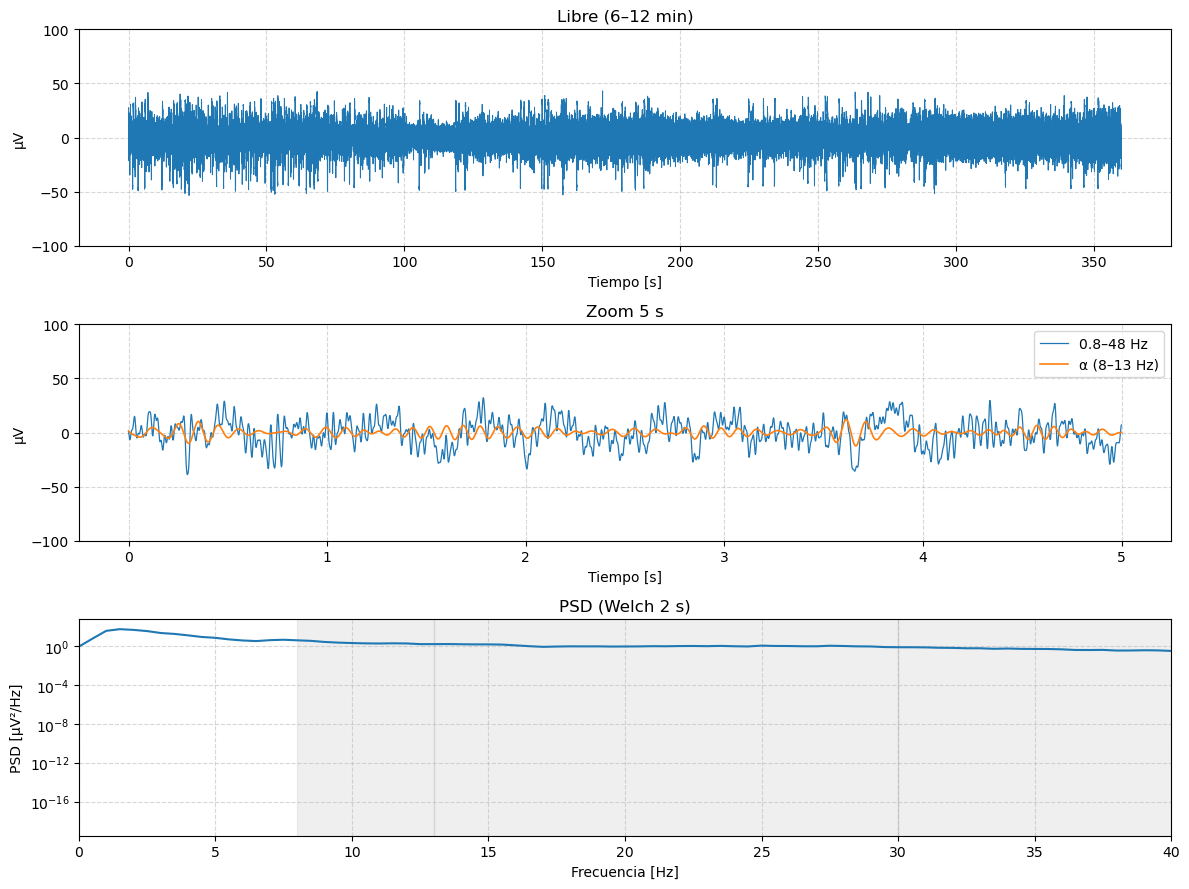

In [11]:
import json, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ===== Config =====
ruta = "Data_EEG/lab5.txt"
bloque = (360, 720)                # 6–12 min
zoom_window = 5.0               # s
f_lo, f_hi = 0.8, 48.0          # Hz
red, Q_notch = 50.0, 30.0       # cambia red=60.0 si tu red es 60 Hz
BANDAS = {"alpha": (8,13), "beta": (13,30), "gamma": (30,48)}

# ===== Leer header (fs y columna A4) =====
with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
    hdr = []
    while True:
        p = f.tell(); ln = f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ===== Cargar y convertir ADC→µV (BITalino EEG) =====
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float)
adc = adc[~np.isnan(adc)]
x = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6  # µV

# ===== Filtros: notch + band-pass =====
bN, aN = iirnotch(red/(fs/2), Q_notch)
x = filtfilt(bN, aN, x, method="gust")
bB, aB = butter(4, [f_lo/(fs/2), f_hi/(fs/2)], btype="band")
x = filtfilt(bB, aB, x, method="gust")

# ===== Recorte del bloque =====
i1, i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x))
t = np.arange(len(x))/fs
t_seg, x_seg = t[i1:i2], x[i1:i2]

# ===== Welch (2 s) y potencias por banda (np.trapezoid) =====
f, Pxx = welch(x_seg, fs=fs, nperseg=2*fs, noverlap=fs)
def band_power(f, P, a, b):
    m = (f >= a) & (f <= b)
    return np.trapezoid(P[m], f[m]) if np.any(m) else 0.0
bp = {k: band_power(f, Pxx, a, b) for k,(a,b) in BANDAS.items()}
print("[Basal 1] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ===== Zoom 5 s (final del bloque) y α superpuesta =====
t2z = t_seg[-1]; t1z = max(t2z - zoom_window, t_seg[0])
j1, j2 = int(t1z*fs), int(t2z*fs)
t_zoom, x_zoom = t[j1:j2], x[j1:j2]
bA, aA = butter(4, [8/(fs/2), 13/(fs/2)], btype="band")
x_alpha = filtfilt(bA, aA, x_zoom, method="gust")

# ===== Gráficas =====
plt.figure(figsize=(12,9))
ax1 = plt.subplot(3,1,1); ax1.plot(t_seg - t_seg[0], x_seg, lw=.7)
ax1.set_title("Libre (6–12 min)"); ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True, ls="--", alpha=.5); ax1.set_ylim(-100, 100)

ax2 = plt.subplot(3,1,2)
ax2.plot(t_zoom - t_zoom[0], x_zoom, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom - t_zoom[0], x_alpha, lw=1.2, label="α (8–13 Hz)")
ax2.set_title("Zoom 5 s"); ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True, ls="--", alpha=.5); ax2.legend(); ax2.set_ylim(-100, 100)

ax3 = plt.subplot(3,1,3)
ax3.semilogy(f, Pxx)
for a,b in BANDAS.values(): ax3.axvspan(a, b, color="grey", alpha=.12)
ax3.set_xlim(0, 40); ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)"); ax3.grid(True, ls="--", alpha=.5)
plt.tight_layout(); plt.show()

# Comparación

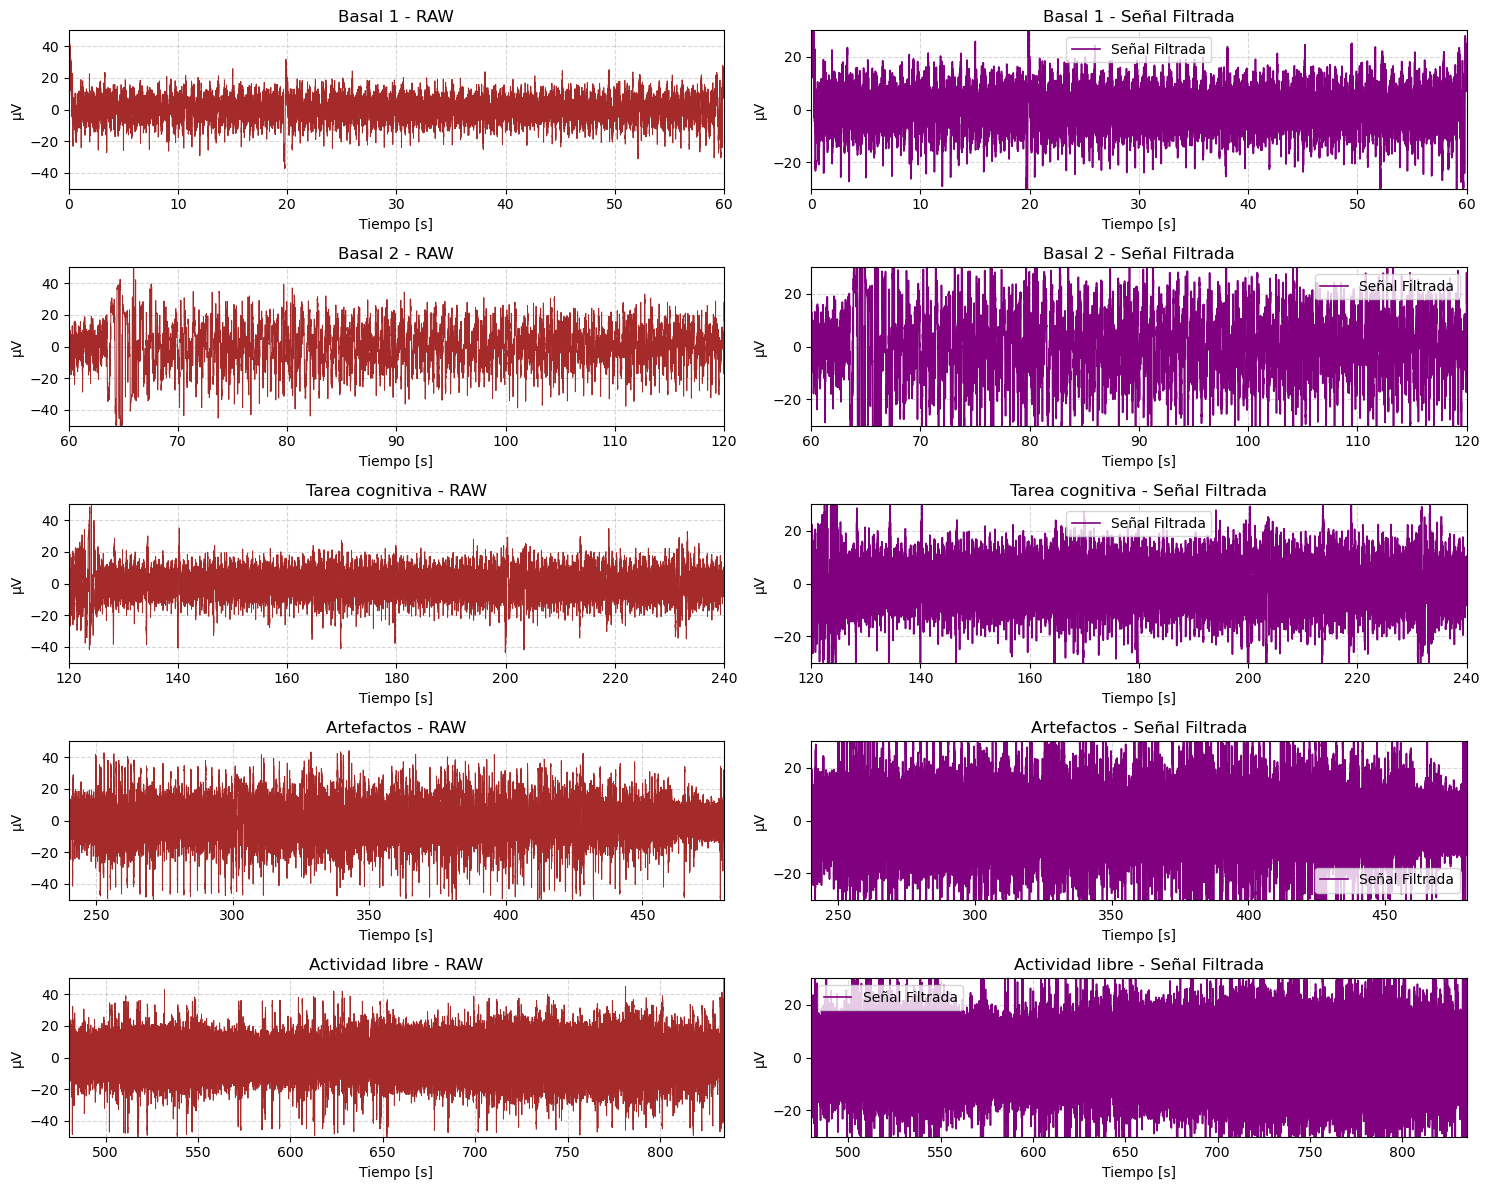

In [40]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ===== Config =====
ruta = "Data_EEG/lab5.txt"  # Asegúrate de que el archivo esté en la ruta correcta
bloques = [
    (0, 60),    # Primer bloque: de 0 a 60
    (60, 120),  # Segundo bloque: de 60 a 120
    (120, 240), # Tercer bloque: de 120 a 240
    (240, 480), # Cuarto bloque: de 240 a 480
    (480, None)  # Último bloque: de 480 hasta el final
]

# ===== Leer header (fs y columna A4) =====
with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
    hdr = []
    while True:
        p = f.tell(); ln = f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])  # Asegúrate de que fs sea correcto
idx_A4 = meta[dev]["column"].index("A4")

# ===== Cargar y convertir ADC→µV (BITalino EEG) =====
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float)
adc = adc[~np.isnan(adc)]
x = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6  # µV

# ===== Filtros: notch + band-pass =====
bN, aN = iirnotch(50/(fs/2), 30)  # Asegúrate de que el filtro notch sea correcto
x = filtfilt(bN, aN, x)  # Aplicamos el filtro notch
bB, aB = butter(4, [0.8/(fs/2), 48/(fs/2)], btype="band")  # Filtro band-pass
x = filtfilt(bB, aB, x)  # Aplicamos el filtro band-pass

# ===== Función de Recorte y Potencias =====
def procesar_bloque(bloque):
    i1, i2 = int(bloque[0]*fs), int(bloque[1]*fs) if bloque[1] is not None else len(x)
    t = np.arange(i1, i2) / fs  # Generamos el tiempo para este bloque
    x_seg = x[i1:i2]
    return t, x_seg

# ===== Gráficas para diferentes condiciones =====
condiciones = ["Basal 1", "Basal 2", "Tarea cognitiva", "Artefactos", "Actividad libre"]
plt.figure(figsize=(15,12))

# Ajustar los gráficos según los bloques
for i, bloque in enumerate(bloques):
    # Procesamos el bloque
    t_seg, x_seg = procesar_bloque(bloque)
    
    # Primer gráfico: Señal cruda
    ax = plt.subplot(5, 2, i*2+1)
    ax.plot(t_seg, x_seg, lw=0.7, color="brown")
    ax.set_title(f"{condiciones[i]} - RAW")
    ax.set_xlabel("Tiempo [s]")
    ax.set_ylabel("µV")
    ax.grid(True, ls="--", alpha=0.5)
    ax.set_ylim(-50, 50)  # Limitar amplitud de la señal cruda entre -50 y 50 µV
    ax.set_xlim(bloque[0], bloque[1] if bloque[1] is not None else len(x)/fs)  # Limitar el eje X al rango del bloque
    
    # Segundo gráfico: Señal filtrada
    ax = plt.subplot(5, 2, i*2+2)
    ax.plot(t_seg, x_seg, lw=1.2, label="Señal Filtrada", color="purple")
    ax.set_title(f"{condiciones[i]} - Señal Filtrada")
    ax.set_xlabel("Tiempo [s]")
    ax.set_ylabel("µV")
    ax.grid(True, ls="--", alpha=0.5)
    ax.set_ylim(-30, 30)  # Limitar amplitud de la señal filtrada entre -30 y 30 µV
    ax.set_xlim(bloque[0], bloque[1] if bloque[1] is not None else len(x)/fs)  # Limitar el eje X al rango del bloque
    ax.legend()

plt.tight_layout()
plt.show()


## ☝️Extra - Resultados Ultracortex Mark M IV

Se preparo el ultracortex y se empezó las mediciones por unos 10 minutos repitiendo los patrones hechos anteriormente en los basales, luego se plotearon la salida de los 8 canales que nos brinda el software del ultracortex.

Para ver el video de la toma de datos del ultracortex, hacer clic [aqui](https://github.com/angelcebrianupch/GRUPO-02-ISB-2025-II/issues/8#issue-3438681638)

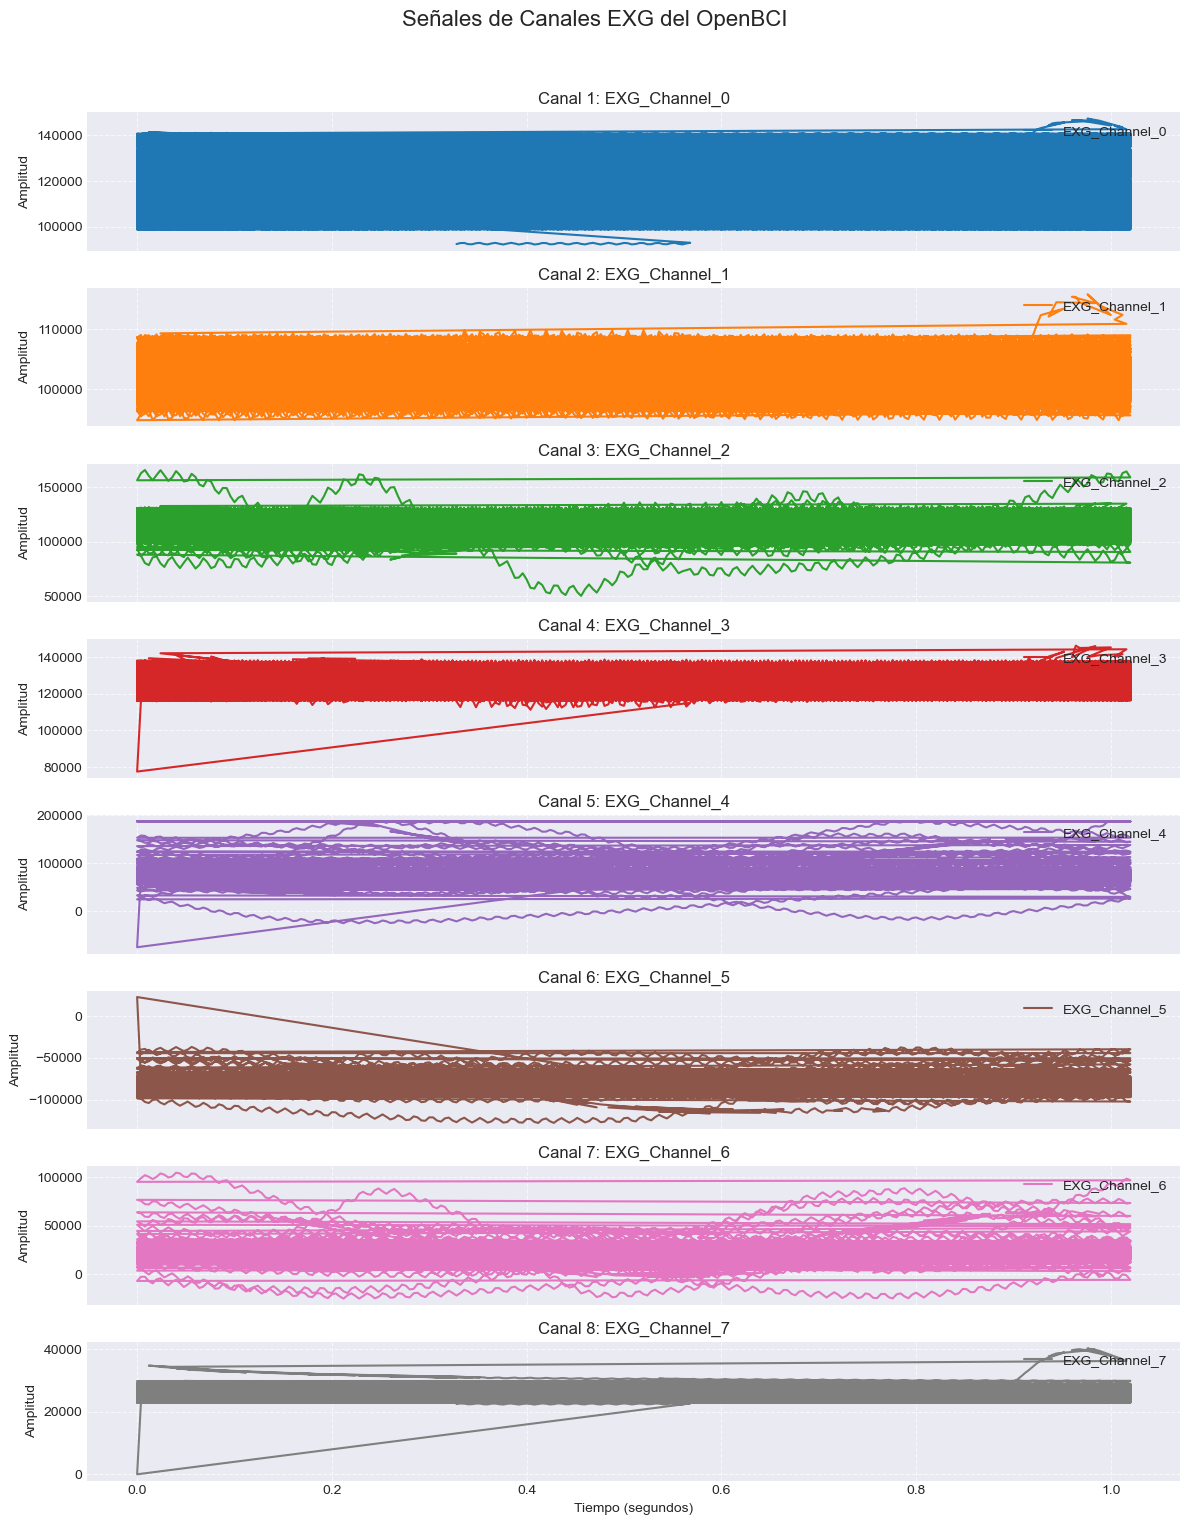

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_eeg_channels(file_path):
    """
    Plotea los 8 canales EXG de un archivo OpenBCI Raw EXG Data.

    Args:
        file_path (str): La ruta al archivo de datos.
    """
    try:
        # Lee el archivo CSV, omitiendo las primeras 4 filas del encabezado
        df = pd.read_csv(file_path, skiprows=4)

        # Renombro las columnas para facilitar el acceso, eliminando espacios y caracteres especiales
        df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '')

        # Identificar las columnas de los canales EXG
        exg_channels = [col for col in df.columns if 'EXG_Channel' in col]

        # Verificar que se encontraron los 8 canales EXG
        if len(exg_channels) != 8:
            print(f"Advertencia: Se esperaban 8 canales EXG, pero se encontraron {len(exg_channels)}. Asegúrate de que los nombres de las columnas sean correctos.")
            print(f"Canales encontrados: {exg_channels}")
            return

        # Obtener la tasa de muestreo del encabezado del archivo
        with open(file_path, 'r') as f:
            for _ in range(3): # 
                line = f.readline()
                if 'Sample Rate' in line:
                    sample_rate = float(line.split('=')[1].strip().split(' ')[0])
                    break
            else:
                print("Advertencia: No se pudo encontrar la 'Sample Rate' en el encabezado del archivo. Se usará 250 Hz por defecto.")
                sample_rate = 250 # Valor por defecto si no se encuentra

        # Crear un eje de tiempo basado en la tasa de muestreo
        if 'Sample_Index' in df.columns:
            time = df['Sample_Index'] / sample_rate
        else:
            time = np.arange(len(df)) / sample_rate
            print("Advertencia: Columna 'Sample_Index' no encontrada. Se generará el eje de tiempo basado en el número de filas.")

        # Configurar el estilo de las gráficas para que se parezca a MATLAB
        plt.style.use('seaborn-v0_8-darkgrid') # Genera grid

        # Crear una figura y un conjunto de subgráficas (8 en total)
        fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(12, 16), sharex=True)
        fig.suptitle('Señales de Canales EXG del OpenBCI', fontsize=16)

        # Plotear cada canal EXG en su propia subgráfica
        for i, channel_name in enumerate(exg_channels):
            axes[i].plot(time, df[channel_name], label=channel_name, color=f'C{i}') # C0, C1, ... para colores automáticos
            axes[i].set_ylabel('Amplitud')
            axes[i].set_title(f'Canal {i+1}: {channel_name}')
            axes[i].grid(True, linestyle='--', alpha=0.7) # Rejilla con estilo
            axes[i].legend(loc='upper right') # Leyenda para cada canal

        # Configurar el eje X para la última subgráfica
        axes[-1].set_xlabel('Tiempo (segundos)')

        # Ajustar el layout para evitar superposiciones
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Ajusta el título principal

        # Mostrar la gráfica
        plt.show()

    except FileNotFoundError:
        print(f"Error: El archivo '{file_path}' no fue encontrado.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

# Ruta al archivo de datos
file_name = 'C:/Users/DAVID/Downloads/Data_EEGlab5.txt' # Asegúrate de que esta ruta sea correcta

# Llamar a la función para plotear los canales
plot_eeg_channels(file_name)

# ✍🏻 Discusión

Los registros obtenidos con el sistema BITalino permitieron observar diferentes condiciones de actividad cerebral: basal, tarea cognitiva, artefactos oculares y actividad libre. Las señales mostraron características consistentes con lo reportado en literatura: durante el reposo se evidenció actividad alfa (8–13 Hz), mientras que en la detección de parpadeos los artefactos se manifestaron como deflexiones lentas de gran amplitud, concentrando energía en bajas frecuencias. Estos hallazgos reflejan que, a pesar de las limitaciones instrumentales, los equipos portátiles pueden capturar patrones electrofisiológicos comparables a los obtenidos en sistemas clínicos. [4]

Estudios de validación han demostrado que la calidad de la señal de dispositivos móviles, aunque inferior en resolución y con mayor susceptibilidad a ruido, mantiene concordancia aceptable con equipos médicos en términos de potencia espectral y detección de ritmos característicos. Esto respalda la utilización de plataformas accesibles como BITalino en entornos universitarios y de investigación aplicada, especialmente en tareas de enseñanza, prototipado y evaluación exploratoria de estados cognitivos [5].

Además, la detección de artefactos oculares es un aspecto crítico en este tipo de registros, dado que los parpadeos pueden enmascarar la actividad cerebral de interés. El uso de filtros y técnicas automáticas de separación, como los algoritmos basados en modelos estadísticos, se plantea en la literatura como una estrategia robusta para mitigar este problema, lo que abre oportunidades de incorporar herramientas de procesamiento avanzado incluso en registros con hardware de bajo costo [6].

En el caso de los datos tomados con ultracortex los datos ploteados fueron muy confusos a pesar de una gran precisión que este deberia brindar gracias a las especificaciones de 8 canales de su guia online, pero se espera que estos datos variados y confusos se deban a errores de contacto debido al cabello al momento de medir o un mayor tiempo de pruebas con el Ultracortex por lo que el BITALINO brindo una mejor lectura de EEG [7].

# 📚 Conclusión

En conjunto, los resultados muestran que el empleo de sistemas portátiles como BITalino ofrece un acceso fiable a la exploración de la actividad cerebral en diferentes contextos experimentales, facilitando tanto la docencia como la investigación inicial. Si bien las limitaciones técnicas restringen su aplicación clínica directa, la comparación con la literatura internacional confirma que los patrones básicos de la dinámica cerebral —actividad alfa en reposo, artefactos por parpadeo y variaciones en tareas cognitivas— son detectables y consistentes [5]. Esto justifica la validez del uso de estos datos como modelo aproximado y educativo, siempre que se reconozcan y mitiguen los artefactos mediante técnicas adecuadas de procesamiento de señal [6].

# 📚 Biliografía
[1] Chaddad A, Wu Y, Kateb R, Bouridane A. Electroencephalography signal processing: A comprehensive review and analysis of methods and techniques. Sensors (Basel) [Internet]. 2023;23(14). Disponible en: http://dx.doi.org/10.3390/s23146434

[2] Khosla A, Khandnor P, Chand T. A comparative analysis of signal processing and classification methods for different applications based on EEG signals. Biocybern Biomed Eng [Internet]. 2020;40(2):649–90. Disponible en: http://dx.doi.org/10.1016/j.bbe.2020.02.002

[3] Oostenveld R, Praamstra P. The five percent electrode system for high-resolution EEG and ERP measurements. Clin Neurophysiol [Internet]. 2001;112(4):713–9. Disponible en: http://dx.doi.org/10.1016/s1388-2457(00)00527-7

[4] Batista D, Plácido da Silva H, Fred A, Moreira C, Reis M, Ferreira HA. Benchmarking of the BITalino biomedical toolkit against an established gold standard. Healthc Technol Lett [Internet]. 2019;6(2):32–6. Disponible en: http://dx.doi.org/10.1049/htl.2018.5037

[5] Kutafina E, Brenner A, Titgemeyer Y, Surges R, Jonas S. Comparison of mobile and clinical EEG sensors through resting state simultaneous data collection. PeerJ [Internet]. 2020;8:e8969. Disponible en: http://dx.doi.org/10.7717/peerj.8969

[6] Cao J, Chen L, Hu D, Dong F, Jiang T, Gao W, et al. Unsupervised eye blink artifact detection from EEG with Gaussian mixture model. IEEE J Biomed Health Inform [Internet]. 2021;25(8):2895–905. Disponible en: http://dx.doi.org/10.1109/JBHI.2021.3057891

[7] L. Mahler, J. Steiglechner, B. Bender, T. Lindig, D. Ramadan, J. Bause, F. Birk, R. Heule, E. Charyasz, M. Erb, V. Jangir Kumar, G. E. Hagberg, P. Martin, G. Lohmann, et al., “Submillimeter Ultra-High Field 9.4 T Brain MR Image Collection and Manual Cortical Segmentations,” Scientific Data, vol. 12, Art. no. 635, Apr. 2025, doi: 10.1038/s41597-025-04779-2.